<a href="https://colab.research.google.com/github/HUJameson/Colab/blob/main/aillm_0305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers accelerate transformers

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

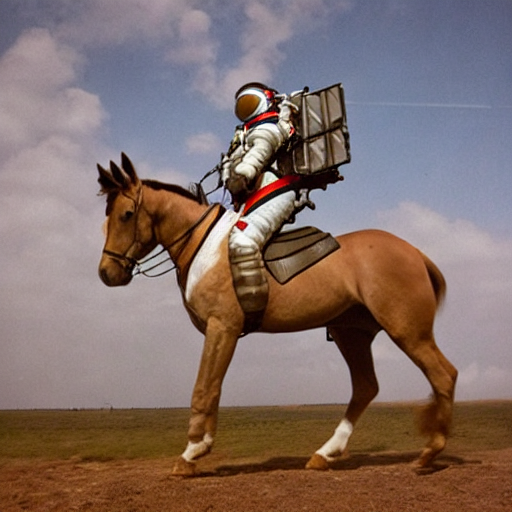

In [ ]:
from diffusers import DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline.to("cuda")
image = pipeline("a photograph of an astronaut riding a horse").images[0]
image

In [ ]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

<ipython-input-12-ba37b6243f8e>:25: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/26 [00:00<?, ?it/s]

'Denoised Sample @ Step 0'

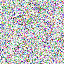

'Decoded Image @ step 0'

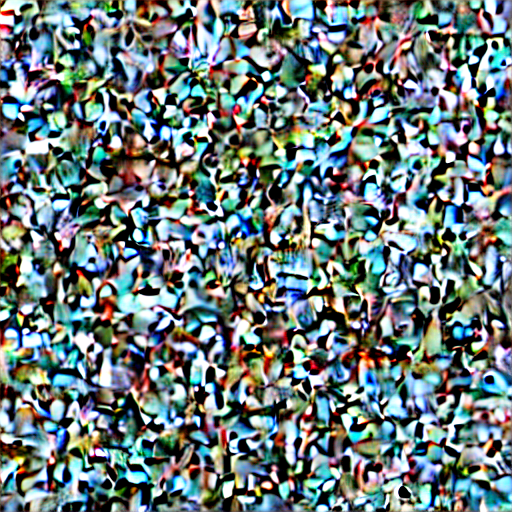

'Denoised Sample @ Step 5'

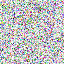

'Decoded Image @ step 5'

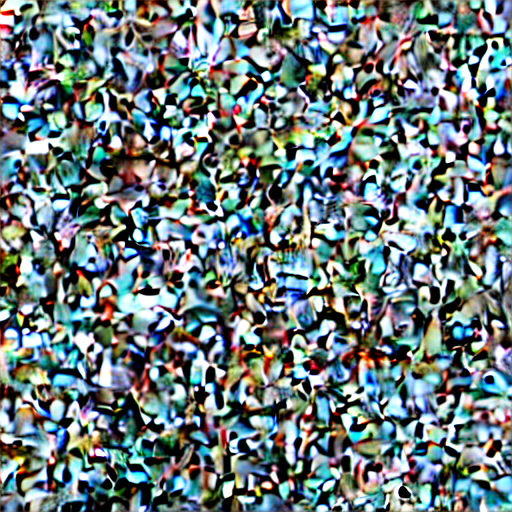

'Denoised Sample @ Step 10'

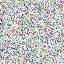

'Decoded Image @ step 10'

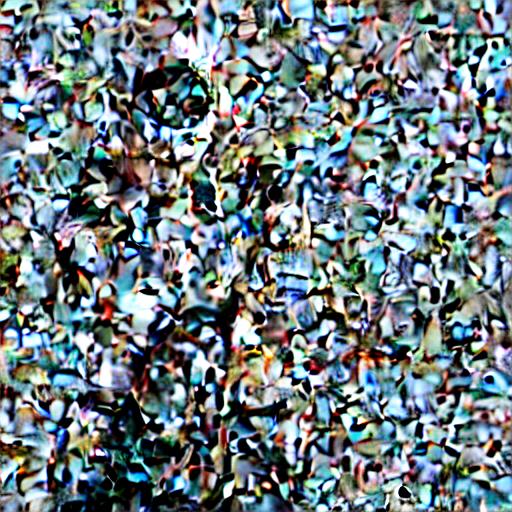

'Denoised Sample @ Step 15'

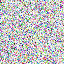

'Decoded Image @ step 15'

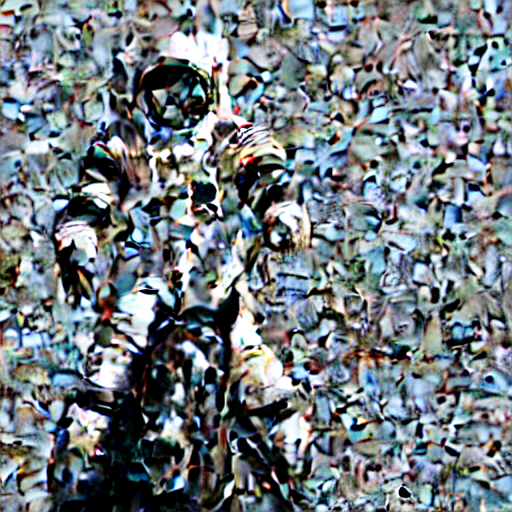

'Denoised Sample @ Step 20'

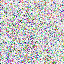

'Decoded Image @ step 20'

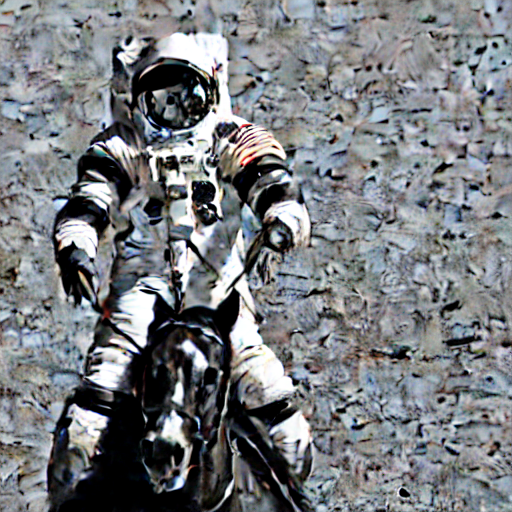

'Denoised Sample @ Step 25'

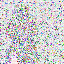

'Decoded Image @ step 25'

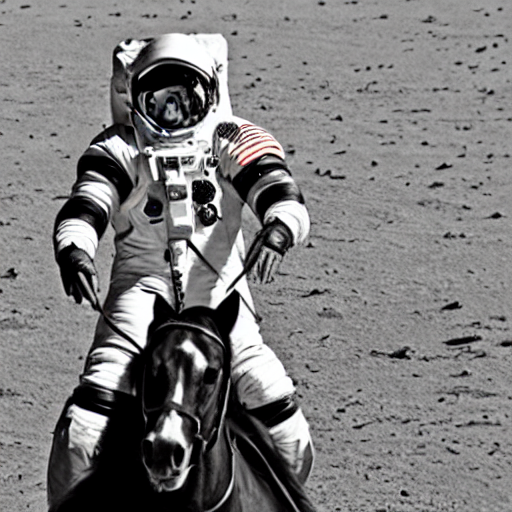

In [ ]:
import torch

prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(42)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

latents = latents * scheduler.init_noise_sigma

import PIL
import torch
import numpy as np
from PIL import Image
from IPython.display import display

def display_denoised_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Denoised Sample @ Step {i}")
    display(image_pil)
    return image_pil

def display_decoded_image(latents, i):
  # scale and decode the image latents with vae
  latents = 1 / 0.18215 * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(f"Decoded Image @ step {i}")
    display(pil_images[0])
    return pil_images[0]


from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

denoised_images = []
decoded_images = []
for i, t in enumerate(tqdm(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    if i % 5 == 0:
      denoised_image = display_denoised_sample(latents, i)
      decoded_image = display_decoded_image(latents, i)
      denoised_images.append(denoised_image)
      decoded_images.append(decoded_image)

In [ ]:
print(latents.shape)
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
    print(image.shape)

torch.Size([1, 4, 64, 64])
torch.Size([1, 3, 512, 512])


In [21]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/37 [00:00<?, ?it/s]

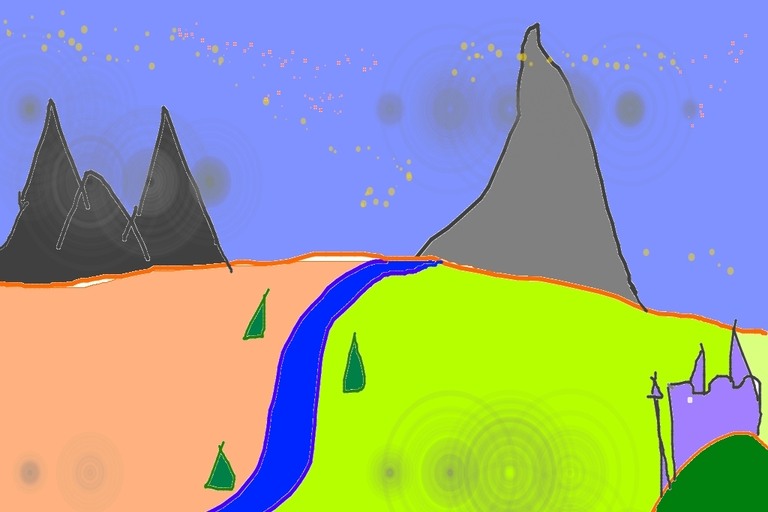

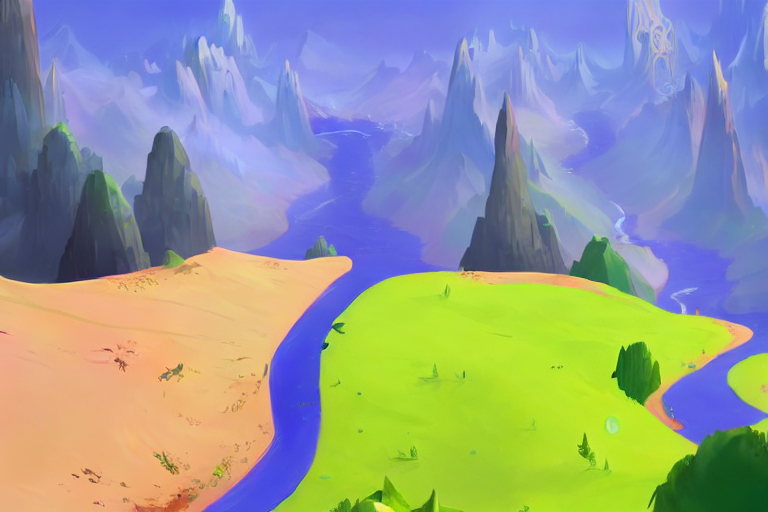

In [17]:
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

image_file = "./data/sketch-mountains-input.jpg"

init_image = Image.open(image_file).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

display(init_image)
display(images[0])

  0%|          | 0/37 [00:00<?, ?it/s]

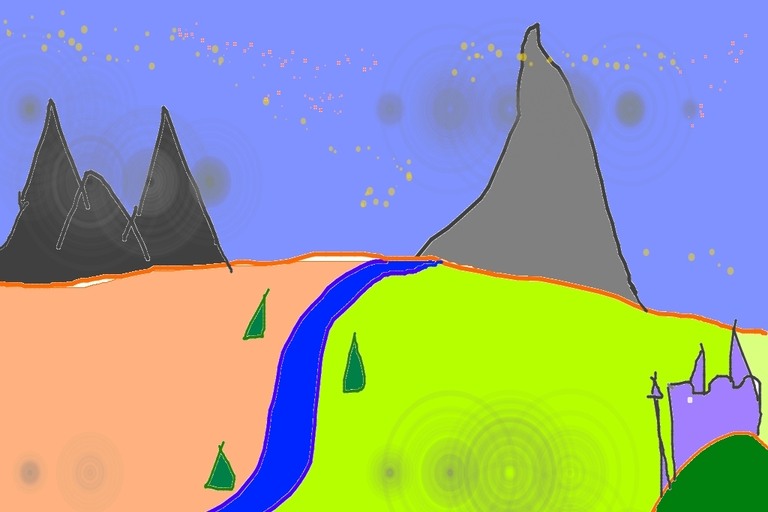

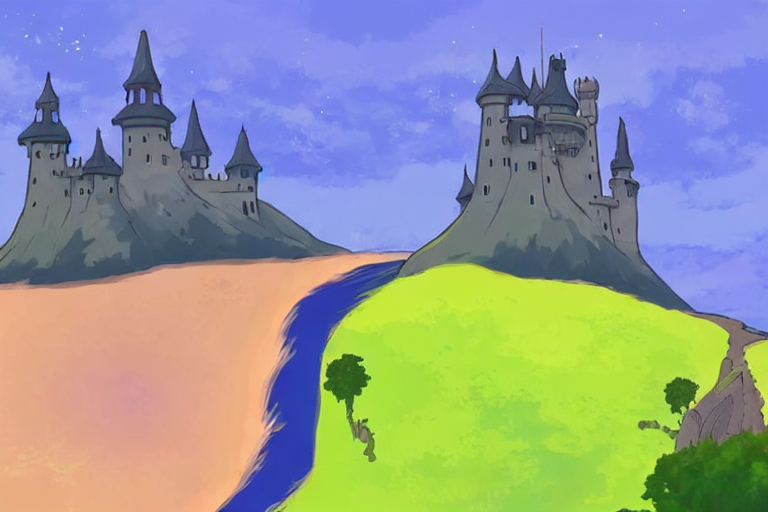

In [18]:
prompt = "ghibli style, a fantasy landscape with castles"
images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

display(init_image)
display(images[0])

  0%|          | 0/37 [00:00<?, ?it/s]

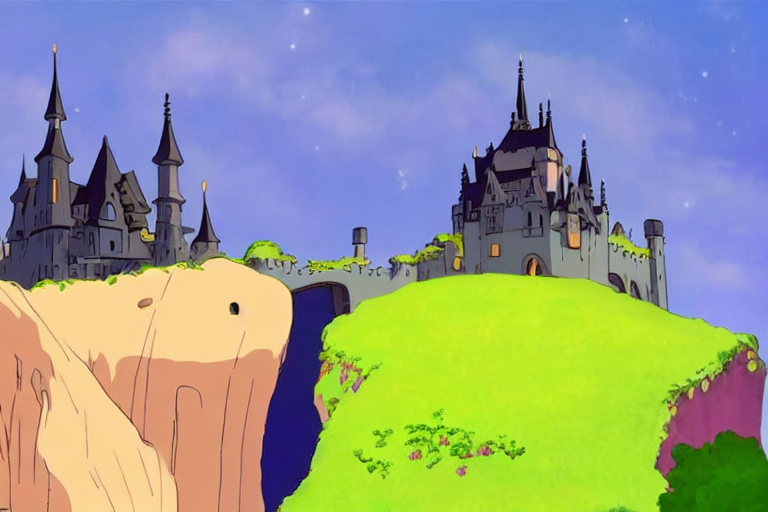

In [19]:
prompt = "ghibli style, a fantasy landscape with castles"
negative_prompt = "river"
images = pipe(prompt=prompt, negative_prompt=negative_prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

display(images[0])

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

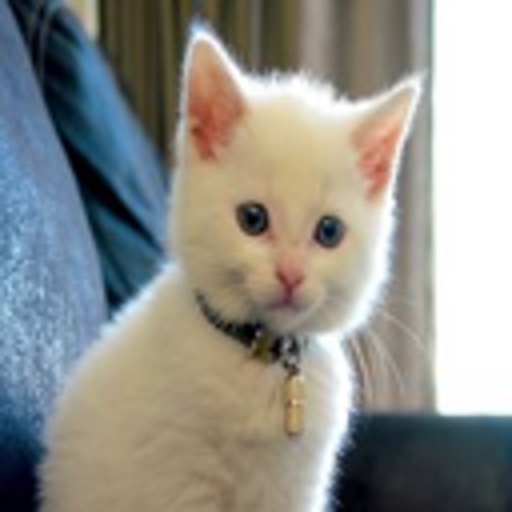

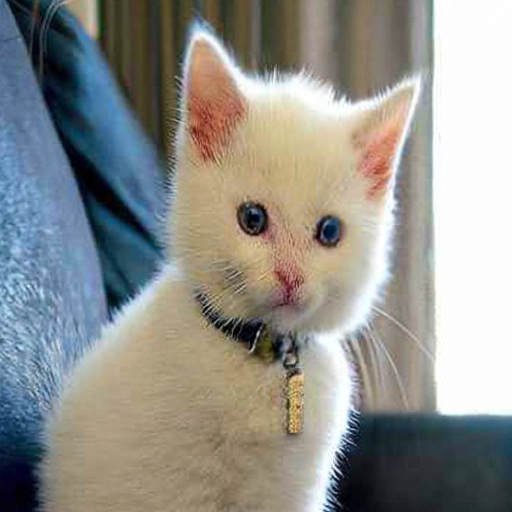

In [22]:
from diffusers import StableDiffusionUpscalePipeline

# load model and scheduler
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

# let's download an  image
low_res_img_file = "./data/low_res_cat.png"
low_res_img = Image.open(low_res_img_file).convert("RGB")
low_res_img = low_res_img.resize((128, 128))

prompt = "a white cat"

upscaled_image = pipeline(prompt=prompt, image=low_res_img).images[0]

low_res_img_resized = low_res_img.resize((512, 512))

display(low_res_img_resized)
display(upscaled_image)

In [25]:
from diffusers import DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained("gsdf/Counterfeit-V2.5")
pipeline.to("cuda")

prompt = "((masterpiece,best quality)),1girl, solo, animal ears, rabbit, barefoot, knees up, dress, sitting, rabbit ears, short sleeves, looking at viewer, grass, short hair, smile, white hair, puffy sleeves, outdoors, puffy short sleeves, bangs, on ground, full body, animal, white dress, sunlight, brown eyes, dappled sunlight, day, depth of field"
negative_prompt = "EasyNegative, extra fingers,fewer fingers,"
image = pipeline(prompt=prompt, negative_prompt=negative_prompt).images[0]
image

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: ignored